In [1]:
import pandas as pd
import numpy as np
from utils import reduce_memory_usage
from utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import joblib
import zipfile
import os
import category_encoders
from sklearn.preprocessing import StandardScaler
import joblib
import zipfile
import os
import holidays

warnings.filterwarnings('ignore')

# Specify the ZIP file name
zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")

In [2]:
def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 100) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

def circular_encode(feature, max_value):
    sin_encoded = np.sin(2 * np.pi * feature / max_value)
    cos_encoded = np.cos(2 * np.pi * feature / max_value)
    return sin_encoded, cos_encoded

In [3]:
df = df[df['site_id'].isin([1, 6])]
df['log_meter_reading']=np.log1p(df['meter_reading'])
df['log_square_feet']=np.log1p(df['square_feet'])
df= break_datetime(df)
df.drop(['year_built', 'floor_count'], axis=1,inplace=True)
df= nan_fillers(df)
df['cloud_coverage'].fillna(df['cloud_coverage'].median(), inplace=True)
df['sea_level_pressure'].fillna(df['sea_level_pressure'].median(), inplace=True)
df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].median(), inplace=True)
df=df.sort_values(by='timestamp')
df['month_sin'], df['month_cos'] = circular_encode(df['month'], 12)
df['hour_sin'], df['hour_cos'] = circular_encode(df['hour'], 24)
df['dayofweek_sin'], df['dayofweek_cos'] = circular_encode(df['dayofweek'], 7)
label_enc= LabelEncoder()
label_enc.fit(df['primary_use'])
df['primary_use_encoded'] = label_enc.transform(df['primary_use'])
df['is_weekday']=df['dayofweek'] <= 5

In [4]:
# Load holiday data for England
england_holidays = holidays.UnitedKingdom(years=range(2016, 2017))

# Load holiday data for the United States
us_holidays = holidays.UnitedStates(years=range(2016, 2017))

# Initialize 'is_holiday' column with zeros
df['is_holiday'] = 0

# Create 'is_holiday_england' feature
england_mask = df['site_id'] == 1
df.loc[england_mask, 'is_holiday'] = df.loc[england_mask, 'timestamp'].apply(lambda x: 1 if x in england_holidays else 0)

# Create 'is_holiday_us' feature
us_mask = df['site_id'] == 6
df.loc[us_mask, 'is_holiday'] = df.loc[us_mask, 'timestamp'].apply(lambda x: 1 if x in us_holidays else 0)

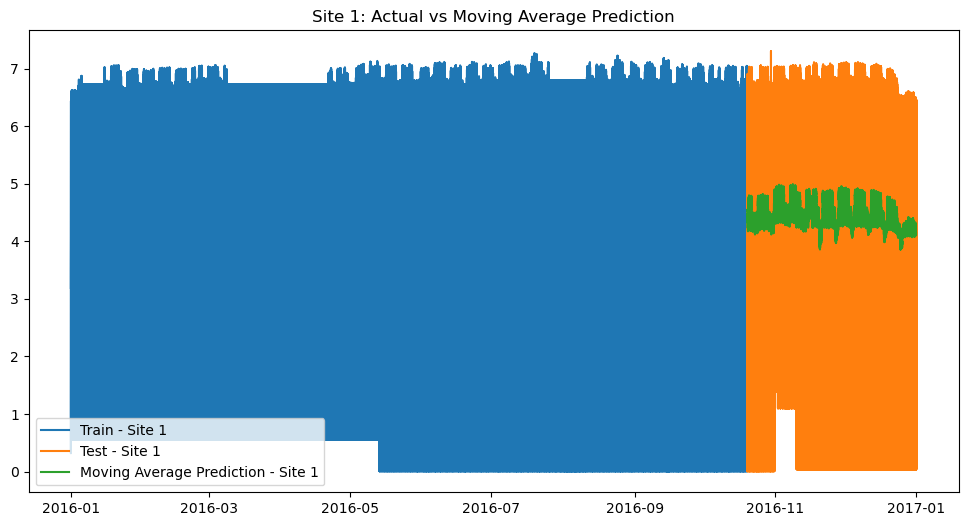

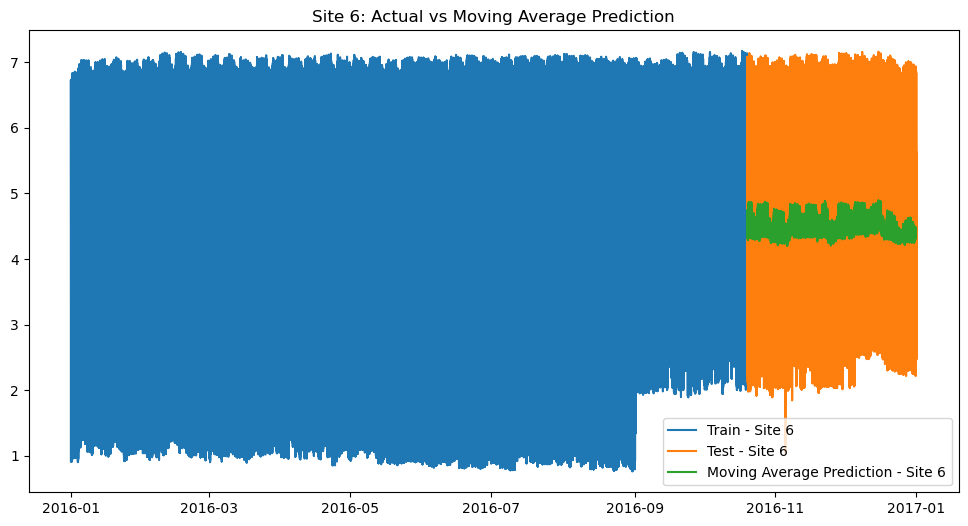

In [42]:
df_site1 = df[df['site_id'] == 1]
df_site6 = df[df['site_id'] == 6]
window_size = 7*24 # Example window size


df_site1['moving_avg'] = df_site1['log_meter_reading'].rolling(window=window_size).mean().shift(-window_size)
df_site6['moving_avg'] = df_site6['log_meter_reading'].rolling(window=window_size).mean().shift(-window_size)

split_point1 = int(len(df_site1) * 0.8)
train_site1 = df_site1.iloc[:split_point1]
test_site1 = df_site1.iloc[split_point1:]

train_site1.dropna()
test_site1.dropna()

split_point6 = int(len(df_site6) * 0.8)
train_site6 = df_site6.iloc[:split_point6]
test_site6 = df_site6.iloc[split_point6:]

train_site6.dropna()
test_site6.dropna()


import matplotlib.pyplot as plt

# Plot for Site 1
plt.figure(figsize=(12, 6))
plt.plot(train_site1['timestamp'], train_site1['log_meter_reading'], label='Train - Site 1')
plt.plot(test_site1['timestamp'], test_site1['log_meter_reading'], label='Test - Site 1')
plt.plot(test_site1['timestamp'], test_site1['moving_avg'], label='Moving Average Prediction - Site 1')
plt.title('Site 1: Actual vs Moving Average Prediction')
plt.legend()
plt.show()

# Plot for Site 6
plt.figure(figsize=(12, 6))
plt.plot(train_site6['timestamp'], train_site6['log_meter_reading'], label='Train - Site 6')
plt.plot(test_site6['timestamp'], test_site6['log_meter_reading'], label='Test - Site 6')
plt.plot(test_site6['timestamp'], test_site6['moving_avg'], label='Moving Average Prediction - Site 6')
plt.title('Site 6: Actual vs Moving Average Prediction')
plt.legend()
plt.show()


In [43]:
test_site1 = test_site1.dropna()
test_site6 = test_site6.dropna()

predictions_site1 = test_site1['moving_avg']
actual_site1 = test_site1['log_meter_reading']

predictions_site6 = test_site6['moving_avg']
actual_site6 = test_site6['log_meter_reading']


In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [44]:
mse_site1 = mean_squared_error(actual_site1, predictions_site1)
r2_site1 = r2_score(actual_site1, predictions_site1)
mape_site1 = mean_absolute_percentage_error(actual_site1, predictions_site1)
mae_site1 = mean_absolute_error(actual_site1, predictions_site1)

print("Site 1 Metrics:")
print("MSE:", mse_site1)
print("R2:", r2_site1)
print("MAPE:", mape_site1)
print("MAE:", mae_site1)

mse_site6 = mean_squared_error(actual_site6, predictions_site6)
r2_site6 = r2_score(actual_site6, predictions_site6)
mape_site6 = mean_absolute_percentage_error(actual_site6, predictions_site6)
mae_site6 = mean_absolute_error(actual_site6, predictions_site6)

print("\nSite 6 Metrics:")
print("MSE:", mse_site6)
print("R2:", r2_site6)
print("MAPE:", mape_site6)
print("MAE:", mae_site6)


Site 1 Metrics:
MSE: 1.5442203091082685
R2: 0.03170290230659856
MAPE: 377.5044902963524
MAE: 0.9618550402668672

Site 6 Metrics:
MSE: 1.2400714360604024
R2: -0.010865411520946555
MAPE: 22.043387303935127
MAE: 0.9191821695240165


In [48]:
# Assuming 'timestamp' is your time column and it's already in a proper datetime format
# Adjust the 'freq' parameter as per your time resolution (e.g., 'D' for daily, 'H' for hourly)

mean_actual_1 = train_site1.groupby(pd.Grouper(key='timestamp', freq='H'))['log_meter_reading'].mean()

mean_predicted_1 = test_site1.groupby(pd.Grouper(key='timestamp', freq='H'))['moving_avg'].mean()

In [49]:
comparison_df_1 = pd.DataFrame({
    'Mean Actual': mean_actual_1,
    'Mean Predicted': mean_predicted_1
})


ValueError: x and y must have same first dimension, but have shapes (8781,) and (8784,)

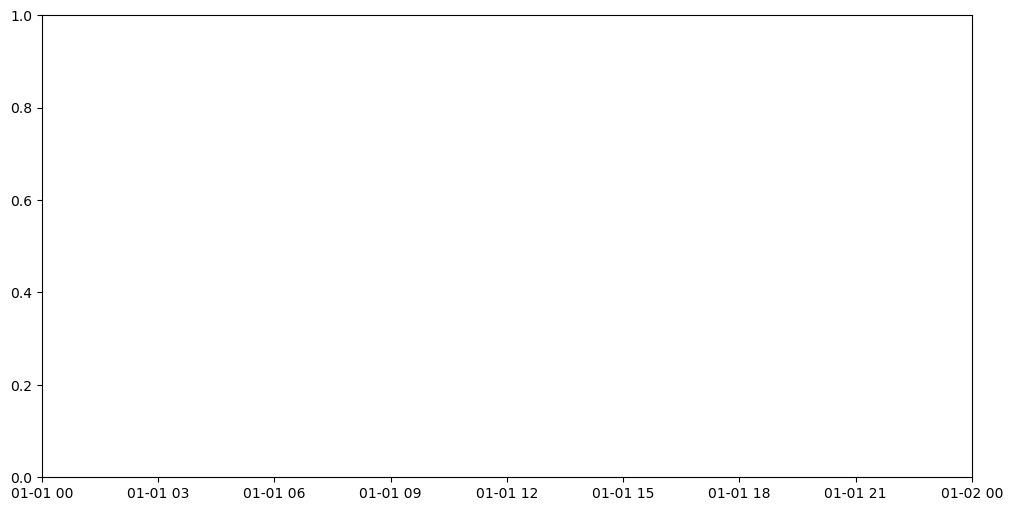

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df_1.index, comparison_df['Mean Actual'], label='Mean Actual')
plt.plot(comparison_df_1.index, comparison_df['Mean Predicted'], label='Mean Predicted', alpha=0.7)
plt.title('Mean Log Meter Reading vs Predicted')
plt.xlabel('Time')
plt.ylabel('Log Meter Reading')
plt.legend()
plt.show()
